### **Step 1: Run Pandaseq to joint NGS raw sequence data**
Pandaseq already installed on Linux system

The raw sequencing data are saved as fastq(fa) files, the final sequencing data are saved as fasta(fa) files

In [ ]:
!pandaseq -F -f /home/shuyuli/Desktop/NGS/L1-R1-input-LGK20357_L2_1.fq -r /home/shuyuli/Desktop/NGS/L1-R1-input-LGK20357_L2_2.fq -d rbfkms -u /home/shuyuli/Desktop/NGS/R1_in_unmerged_pandaseq.fa 2> /home/shuyuli/Desktop/NGS/R1_in_pandastat.txt 1> /home/shuyuli/Desktop/NGS/merged_data/R1_in.fastq
!pandaseq -F -f /home/shuyuli/Desktop/NGS/raw_data/L1-R1-output-LGK20358_L2_1.fq -r /home/shuyuli/Desktop/NGS/L1-R1-output-LGK20358_L2_2.fq -d rbfkms -u /home/shuyuli/Desktop/NGS/R1_out_unmerged_pandaseq.fa 2> /home/shuyuli/Desktop/NGS/R1_out_pandastat.txt 1> /home/shuyuli/Desktop/NGS/merged_data/R1_out.fastq
!pandaseq -F -f /home/shuyuli/Desktop/NGS/raw_data/L1-R4-input-LGK20359_L2_1.fq -r /home/shuyuli/Desktop/NGS/L1-R4-input-LGK20359_L2_2.fq -d rbfkms -u /home/shuyuli/Desktop/NGS/R4_in_unmerged_pandaseq.fa 2> /home/shuyuli/Desktop/NGS/R4_in_pandastat.txt 1> /home/shuyuli/Desktop/NGS/merged_data/R4_in.fastq
!pandaseq -F -f /home/shuyuli/Desktop/NGS/raw_data/L1-R4-output-LGK20360_L2_1.fq -r /home/shuyuli/Desktop/NGS/L1-R4-output-LGK20360_L2_2.fq -d rbfkms -u /home/shuyuli/Desktop/NGS/R4_out_unmerged_pandaseq.fa 2> /home/shuyuli/Desktop/NGS/R4_out_pandastat.txt 1> /home/shuyuli/Desktop/NGS/merged_data/R4_out.fastq

### **Analyse NGS data**
 

In [ ]:
import os
import csv
from collections import Counter

import pandas as pd
from Bio.Seq import Seq
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# 定Define the base complementation table
complement = str.maketrans("ACGT", "TGCA")

# The input and output file pathes, need to change file names to each round merged data
input_fastq = r"D:/Zeng Lab/NGS/merged_data/R4_out.fastq"
output_fastq = r"D:/Zeng Lab/NGS/merged_data/R4_out_corrected.fastq"

# 5' end sequencing primers
sequencing_primer = "GAACAACGTGGGCATTCG"

os.makedirs(os.path.dirname(output_fastq), exist_ok=True)

This script processes a FASTQ file to ensure all sequences are in the 5'→3' top strand orientation.
If a sequence is determined to be from the bottom strand, it is converted to its reverse complement,
and the quality scores are reversed accordingly.

In [ ]:
def reverse_complement(seq):
    """Get the reverse complement of a sequence."""
    return seq.translate(complement)[::-1]  # Complement first, then reverse

def is_top_strand(seq, primer, min_match=3):
    """Determine if the sequence is in the top strand:
       - If the first min_match (default: 3) bases of the sequence match the 5' end of the sequencing primer,
         it is considered a top strand.
       - Otherwise, it is considered a bottom strand.
    """
    return seq[:min_match] in primer[:len(seq)]

def process_fastq(fastq_file, output_fastq):
    corrected_sequences = []  # Store corrected FASTQ records

    with open(fastq_file, 'r') as f:
        lines = f.readlines()
    
    # Iterate through FASTQ data (every 4 lines form a complete record)
    for i in range(0, len(lines), 4):
        header = lines[i].strip()     # FASTQ ID line (starts with @)
        seq = lines[i + 1].strip()    # Sequence line
        plus = lines[i + 2].strip()   # "+" line
        qual = lines[i + 3].strip()   # Quality score line

        # Check if the sequence is in the top strand
        if not is_top_strand(seq, sequencing_primer, min_match=3):  
            seq = reverse_complement(seq)  # Convert to top strand
            qual = qual[::-1]  # Reverse quality scores accordingly

        corrected_sequences.append(f"{header}\n{seq}\n{plus}\n{qual}\n")  # Store modified FASTQ record

    # Save the converted FASTQ file
    with open(output_fastq, "w") as fq_out:
        fq_out.writelines(corrected_sequences)

    print(f"Conversion complete! All sequences have been adjusted to the 5'→3' top strand and saved to {output_fastq}")

# Run processing
process_fastq(input_fastq, output_fastq)


Quality Control: This script processes a FASTQ file to align sequences based on fixed 5' and 3' regions.
Sequences that do not contain both fixed regions are discarded.

In [2]:
# Input and output file paths
input_fastq = r"D:/Zeng Lab/NGS/merged_data/R4_out_corrected.fastq"
output_fastq = r"D:/Zeng Lab/NGS/analysis/R4_out_aligned.fastq"

# Fixed regions at the 5' and 3' ends
five_prime_fixed = "GGCTAT"
three_prime_fixed = "AACAACGAT"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_fastq), exist_ok=True)

def align_sequence(seq):
    """Align sequence to start at the 5' fixed region and end at the 3' fixed region."""
    # Find the position of the 5' fixed region
    start_idx = seq.find(five_prime_fixed)
    if start_idx == -1:
        return None  # Discard sequence if 5' fixed region is not found
    
    # Align from the 5' end
    seq = seq[start_idx:]

    # Find the position of the 3' fixed region
    end_idx = seq.find(three_prime_fixed)
    if end_idx == -1:
        return None  # Discard sequence if 3' fixed region is not found

    # Keep the portion from 5' to 3' fixed region
    return seq[:end_idx + len(three_prime_fixed)]

def process_fastq(fastq_file, output_fastq):
    aligned_sequences = []  # Store aligned FASTQ records
    total, kept = 0, 0  # Count total and retained sequences

    with open(fastq_file, 'r') as f:
        lines = f.readlines()
    
    # Iterate through FASTQ data (every 4 lines form a complete record)
    for i in range(0, len(lines), 4):
        total += 1
        header = lines[i].strip()     # FASTQ ID line (starts with @)
        seq = lines[i + 1].strip()    # Sequence line
        plus = lines[i + 2].strip()   # "+" line
        qual = lines[i + 3].strip()   # Quality score line

        aligned_seq = align_sequence(seq)
        if aligned_seq is None:
            continue  # Discard unaligned sequences

        # Trim quality scores accordingly
        start_idx = seq.find(aligned_seq)
        qual = qual[start_idx:start_idx + len(aligned_seq)]

        aligned_sequences.append(f"{header}\n{aligned_seq}\n{plus}\n{qual}\n")
        kept += 1

    # Save aligned FASTQ file
    with open(output_fastq, "w") as fq_out:
        fq_out.writelines(aligned_sequences)

    print(f"Alignment complete! Total sequences: {total}, Retained sequences: {kept}, Saved to {output_fastq}")

# Run processing
process_fastq(input_fastq, output_fastq)


Alignment complete! Total sequences: 8779499, Retained sequences: 8517645, Saved to D:/Zeng Lab/NGS/analysis/R4_out_aligned.fastq


This script counts the occurrences of unique sequences in an aligned FASTQ file. It extracts sequence lines from the FASTQ file, tallies their frequencies, and saves the results in both TXT and CSV formats. The output is sorted in descending order based on sequence count.

In [3]:
# Input FASTQ file path (aligned sequences)
input_fastq = r"D:/Zeng Lab/NGS/analysis/R1_out_aligned.fastq"
output_txt = r"D:/Zeng Lab/NGS/analysis/R1_out_sequence_counts.txt"
output_csv = r"D:/Zeng Lab/NGS/analysis/R1_out_sequence_counts.csv"

os.makedirs(os.path.dirname(output_txt), exist_ok=True)

def count_sequences(fastq_file):
    """Count unique sequences in a FASTQ file."""
    seq_counter = Counter()
    
    with open(fastq_file, 'r') as f:
        lines = f.readlines()
    
    # FASTQ format: every 4 lines represent a complete record
    for i in range(1, len(lines), 4):  # Process only the sequence lines
        seq = lines[i].strip()
        seq_counter[seq] += 1
    
    return seq_counter

# Count sequences
seq_counts = count_sequences(input_fastq)

# Sort sequences by occurrence in descending order
sorted_counts = sorted(seq_counts.items(), key=lambda x: x[1], reverse=True)

# Save to TXT file
with open(output_txt, 'w') as txt_file:
    for seq, count in sorted_counts:
        txt_file.write(f"{seq}\t{count}\n")

# Save to CSV file
with open(output_csv, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["Sequence", "Count"])  # Header
    writer.writerows(sorted_counts)

print(f"Counting complete! Results saved to:\n- {output_txt}\n- {output_csv}")


Counting complete! Results saved to:
- D:/Zeng Lab/NGS/analysis/R1_out_sequence_counts.txt
- D:/Zeng Lab/NGS/analysis/R1_out_sequence_counts.csv


Quality Control: This script filters sequences from the initial dataset, keeping only those with at least 100 reads. It then calculates the frequency of each retained sequence within the dataset and saves the updated results back to the original CSV file.

In [4]:
# Load the initial dataset before the first round of filtering
input_file = r"D:\Zeng Lab\NGS\analysis\R1_out_sequence_counts.csv"
df_in = pd.read_csv(input_file)

# Filter out sequences with fewer than 100 reads
df_in_filtered = df_in[df_in['Count'] >= 100]

# Calculate the frequency of each sequence in the initial library
total_reads_in = df_in_filtered['Count'].sum()
df_in_filtered['Frequency'] = df_in_filtered['Count'] / total_reads_in

# Save the processed results back to the original CSV file
df_in_filtered.to_csv(input_file, index=False)

print("Processing complete!")

Processing complete!


C:\Users\shuyu\AppData\Local\Temp\ipykernel_19684\3889665797.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_in_filtered['Frequency'] = df_in_filtered['Count'] / total_reads_in


In [5]:
file_path = r"D:\Zeng Lab\NGS\analysis\R1_out_sequence_counts.csv"
df = pd.read_csv(file_path)

# Define a function to translate a DNA sequence into an amino acid sequence
def translate_dna_to_protein(dna_sequence):
    try:
        dna_seq = Seq(dna_sequence)
        return str(dna_seq.translate())  # Translate into an amino acid sequence
    except Exception as e:
        return None  # Return None if translation fails

# Add a new column to store the translated amino acid sequences
df['Amino Acid Sequence'] = df['Sequence'].apply(translate_dna_to_protein)

# Save the updated data back to the original file
df.to_csv(file_path, index=False)

print(f"Updated results have been saved to {file_path}")

Updated results have been saved to D:\Zeng Lab\NGS\analysis\R1_out_sequence_counts.csv


c:\PyMOL\lib\site-packages\Bio\Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [6]:
# Load the original data file
file_path = r"D:\Zeng Lab\NGS\analysis\R1_out_sequence_counts.csv"
df = pd.read_csv(file_path)

# Group by amino acid sequence and calculate the total frequency for each group
grouped_df = df.groupby('Amino Acid Sequence')['Frequency'].sum().reset_index()

# Save the merged data to a new CSV file
output_file = r"D:\Zeng Lab\NGS\analysis\R1_out_protein_frequencies.csv"
grouped_df.to_csv(output_file, index=False)

print(f"Merged results have been saved to {output_file}")

Merged results have been saved to D:\Zeng Lab\NGS\analysis\R1_out_protein_frequencies.csv


In [7]:
# Load the data before and after the first round of screening
input_file = r"D:\Zeng Lab\NGS\analysis\R4_in_protein_frequencies.csv"
df_in = pd.read_csv(input_file)

output_file = r"D:\Zeng Lab\NGS\analysis\R4_out_protein_frequencies.csv"
df_out = pd.read_csv(output_file)

# Merge dataframes based on the amino acid sequence
merged_df = pd.merge(df_in[['Amino Acid Sequence', 'Frequency']], 
                     df_out[['Amino Acid Sequence', 'Frequency']], 
                     on='Amino Acid Sequence', 
                     how='inner', 
                     suffixes=('_in', '_out'))

# Ensure the output directory exists
output_merged_file = r"D:\Zeng Lab\NGS\result\R4_Protein_sequence_frequency_change.csv"
os.makedirs(os.path.dirname(output_merged_file), exist_ok=True)

# Save the merged results to a new file
merged_df.to_csv(output_merged_file, index=False)

print(f"Results have been saved to {output_merged_file}")

Results have been saved to D:\Zeng Lab\NGS\result\R4_Protein_sequence_frequency_change.csv


In [ ]:
file_path = r"D:\Zeng Lab\NGS\result\R4_Protein_sequence_frequency_change.csv"
df = pd.read_csv(file_path)

# Calculate Enrichment Ratio = Ratio after screening / Ratio before screening
df['Enrichment Ratio'] = df['Frequency_out'] / df['Frequency_in']

# Save the updated data back to the original file
df.to_csv(file_path, index=False)

print(f"Enrichment ratio has been calculated and saved to {file_path}")

# Wild-type sequence
wildtype_sequence = "GYMYLKGPRGSVMTTNIYLNSSLYRGTKFIIKKYASGNKDNIVRNND"

# Extract the Enrichment Ratio for the wild-type
wildtype_enrichment_ratio = df[df['Amino Acid Sequence'] == wildtype_sequence]['Enrichment Ratio'].values

# Ensure the Enrichment Ratio for wild-type is found
if len(wildtype_enrichment_ratio) == 0:
    print("Wild-type sequence not found!")
else:
    # Get the Enrichment Ratio for the wild-type (assuming only one)
    wildtype_enrichment_ratio = wildtype_enrichment_ratio[0]

    # Calculate Fitness Score
    df['Fitness Score'] = df['Enrichment Ratio'] / wildtype_enrichment_ratio

    # Save the updated data back to the original file
    df.to_csv(file_path, index=False)

    print(f"Fitness Score has been calculated and saved to {file_path}")


Enrichment ratio has been calculated and saved to D:\Zeng Lab\NGS\result\R4_Protein_sequence_frequency_change.csv
Fitness Score has been calculated and saved to D:\Zeng Lab\NGS\result\R4_Protein_sequence_frequency_change.csv


In [ ]:
# Read the data file
file_path = r"D:\Zeng Lab\NGS\analysis\R4_Protein_sequence_frequency_change.csv"
df = pd.read_csv(file_path)

# Filter out sequences that are not 47 amino acids long or contain '*' 
df_filtered = df[df['Amino Acid Sequence'].apply(lambda x: len(x) == 47 and '*' not in x)]

# Save the processed data to a new file
output_file_path = r"D:\Zeng Lab\NGS\analysis\result\R4_NGS.csv"
df_filtered.to_csv(output_file_path, index=False)

print(f"Filtered data has been saved to {output_file_path}")

Filtered data has been saved to D:\Zeng Lab\NGS\analysis\result\R4_NGS.csv


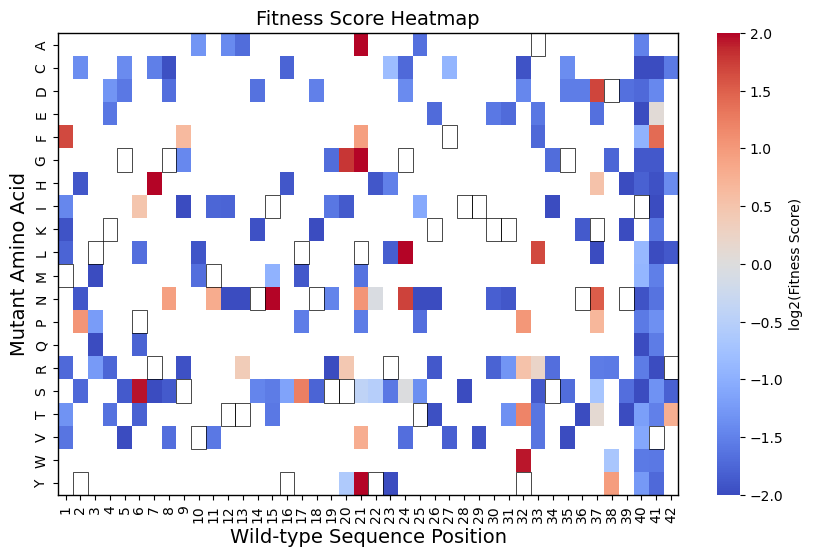

In [23]:
file_path = r"D:\Zeng Lab\NGS\analysis\result\R4_NGS.csv"

# Read the CSV file
df = pd.read_csv(file_path)

# Set the wild-type sequence (keeping only the part starting from the 3rd amino acid)
wt_sequence = "GYMYLKGPRGSVMTTNIYLNSSLYRGTKFIIKKYASGNKDNIVR"
wt_sequence = wt_sequence[2:]  # Keep from the 3rd amino acid onwards
wt_length = len(wt_sequence)
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # 20 standard amino acids

# Renumber the x-axis so that the 3rd amino acid position becomes 1
new_x_labels = list(range(1, wt_length + 1))

# Create an empty DataFrame to store log2(Fitness Score)
heatmap_data = pd.DataFrame(np.nan, index=list(amino_acids), columns=new_x_labels)

# Iterate over the dataset to fill log2(Fitness Score)
for _, row in df.iterrows():
    seq = row["Amino Acid Sequence"][2:]  # Keep only the part starting from the 3rd amino acid
    fitness_score = row["Fitness Score"]
    
    if fitness_score > 0:  # Avoid log2(0) error
        log2_fitness = np.log2(fitness_score)
        
        # Find mutation sites and record log2(Fitness Score)
        for i, (wt_aa, mut_aa) in enumerate(zip(wt_sequence, seq)):
            if wt_aa != mut_aa and mut_aa in amino_acids:
                heatmap_data.loc[mut_aa, i + 1] = log2_fitness  # Renumber x-axis

# Create a mask where NaN values are filled with gray
mask = heatmap_data.isna()

# Generate the heatmap
plt.figure(figsize=(10, 6))
ax = sns.heatmap(heatmap_data, cmap="coolwarm", center=0, mask=mask,  
                 linewidths=0, linecolor='lightgray', cbar_kws={'label': 'log2(Fitness Score)'}, 
                 vmin=-2, vmax=2)

# Mark the wild-type amino acids with black borders (adjust the index to start from the new x-axis number 1)
for i, wt_aa in enumerate(wt_sequence):
    if wt_aa in amino_acids:
        ax.add_patch(plt.Rectangle((i, amino_acids.index(wt_aa)), 1, 1, fill=False, edgecolor='black', lw=0.5))

# Set axis labels
plt.xlabel("Wild-type Sequence Position", fontsize=14)
plt.ylabel("Mutant Amino Acid", fontsize=14)
plt.title("Fitness Score Heatmap", fontsize=14)

# Set border visibility for axes
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1)

# Save the heatmap as a PDF
plt.savefig("D:/Zeng Lab/NGS/analysis/result/R4_fitness_score_heatmap.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

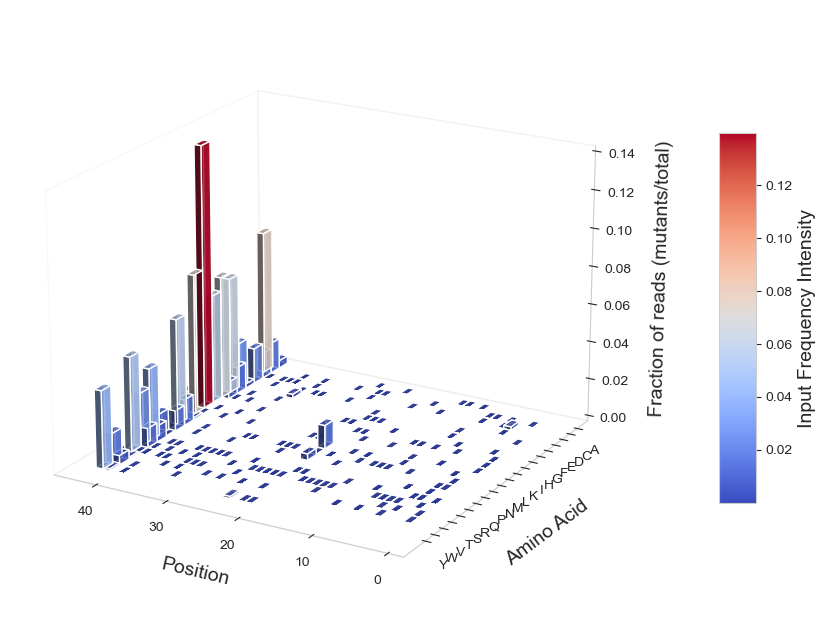

In [ ]:
# Set Seaborn theme
sns.set_style("whitegrid")

# Set the file path
file_path = r"D:\Zeng Lab\NGS\analysis\result\R4_NGS.csv"

# Read the CSV file
df = pd.read_csv(file_path)

# Set the wild-type sequence (starting from the 3rd amino acid)
wt_sequence = "GYMYLKGPRGSVMTTNIYLNSSLYRGTKFIIKKYASGNKDNIVR"[2:]  
wt_length = len(wt_sequence)
amino_acids = "ACDEFGHIKLMNPQRSTVWY"  # 20 standard amino acids
new_x_labels = list(range(1, wt_length + 1))  # Re-label the positions

# Create lists to store data
x_data, y_data, z_data = [], [], []

# Iterate through the data to extract mutation information and 'Frequency_in'
for _, row in df.iterrows():
    seq = row["Amino Acid Sequence"][2:]  # Start from the 3rd amino acid
    freq_in = row["Frequency_in"]
    
    for i, (wt_aa, mut_aa) in enumerate(zip(wt_sequence, seq)):
        if wt_aa != mut_aa and mut_aa in amino_acids:
            x_data.append(i + 1)  # Position
            y_data.append(amino_acids.index(mut_aa))  # Mutant amino acid index
            z_data.append(freq_in)  # Frequency data

# Normalize color mapping
norm = plt.Normalize(min(z_data), max(z_data))
colors = cm.coolwarm(norm(z_data))  # Use the coolwarm color gradient

# Create a 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D bars
x_pos = np.array(x_data)  # x coordinates
y_pos = np.array(y_data)  # y coordinates
z_pos = np.zeros_like(x_pos)  # z coordinates (starting position of bars)
dx = np.ones_like(x_pos)  # Width of each bar
dy = np.ones_like(y_pos)  # Depth of each bar
dz = np.array(z_data)  # Height of each bar, i.e., frequency values

# Draw the bars
ax.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, color=colors, alpha=0.8)

# Set axis labels
ax.set_xlabel("Position", fontsize=14, labelpad=10)
ax.set_ylabel("Amino Acid", fontsize=14, labelpad=10)
ax.set_zlabel("Fraction of reads (mutants/total)", fontsize=14, labelpad=10)
#ax.set_title("3D Bar Plot of Frequency_in", fontsize=14, pad=15)

# Set y-axis tick labels (amino acids)
ax.set_yticks(range(len(amino_acids)))
ax.set_yticklabels(list(amino_acids), fontsize=10)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Show grids on all axes
ax.grid(False)

# Adjust the view angle so the z-axis touches the x-axis
ax.view_init(elev=20, azim=120)  # Adjust angle (elev is the elevation, azim is the azimuth)

# Display grid lines for each axis face
ax.xaxis._axinfo["grid"].update(color="white", linestyle="--")
ax.yaxis._axinfo["grid"].update(color="white", linestyle="--")
ax.zaxis._axinfo["grid"].update(color="white", linestyle="--")

# Add color bar
sm = plt.cm.ScalarMappable(cmap=cm.coolwarm, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, shrink=0.6, aspect=10, pad=0.1)
cbar.set_label("Input Frequency Intensity", fontsize=14)

# Save the plot as PDF
plt.savefig("D:/Zeng Lab/NGS/analysis/result/R4_input_frequency.pdf", format="pdf", bbox_inches="tight")

# Display the plot
plt.show()

In [ ]:
# Set the file path
file_path = r"D:\Zeng Lab\NGS\analysis\result\R4_NGS.csv"

# Read the CSV file
df = pd.read_csv(file_path)

# Filter sequences with Fitness Score greater than 1
df_filtered = df[df['Fitness Score'] > 1]

# Extract the Amino Acid Sequence column
amino_acid_sequences = df_filtered['Amino Acid Sequence']

# Save to a txt file
output_file = r"D:\Zeng Lab\NGS\analysis\result\R4_filtered_sequences.txt"
with open(output_file, 'w') as f:
    for seq in amino_acid_sequences:
        f.write(seq + "\n")  # Write each sequence on a new line

print(f"Filtered sequences saved to {output_file}")

Filtered sequences saved to D:\Zeng Lab\NGS\analysis\result\R4_filtered_sequences.txt
